<a href="https://colab.research.google.com/github/VladousSparrowous/OpenML/blob/main/MLforYandex_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

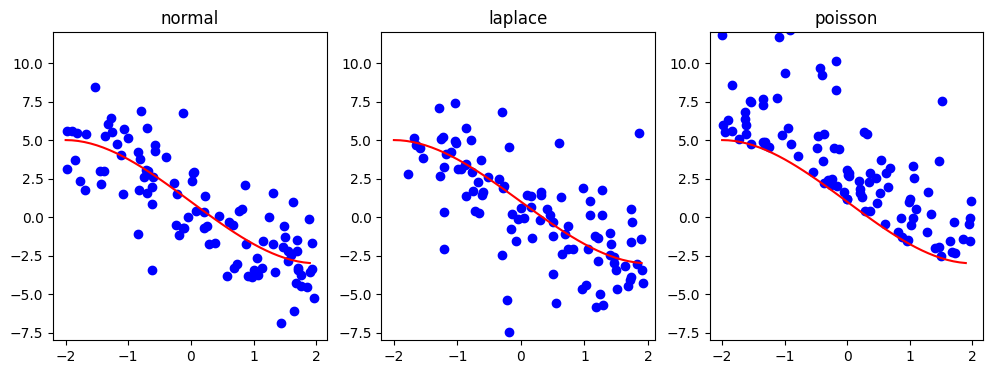

In [ ]:
# @title примеры шума

from scipy.stats import norm, laplace, expon

def f(x):
    return 0.25*x**3 - 3*x + 1

xx = np.arange(-2, 2, 0.1)
yy = f(xx)
N = 100

plt.figure(figsize=(12, 4))

for i, (rvs_func, name) in enumerate([
  (norm.rvs(loc=0, scale=1, size=N, random_state=None), 'normal'),
  (laplace.rvs(loc=0, size=N, random_state=None), 'laplace'),
  (expon.rvs(size=N, random_state=None), 'poisson'),
]):

    plt.subplot(1,3,i+1)
    plt.title(name)
    plt.ylim(-8,12)
    X = np.random.rand(N)*4 - 2
    Y = f(X) + 2*rvs_func

    plt.scatter(X, Y, color='blue')
    plt.plot(xx, yy, color='red')

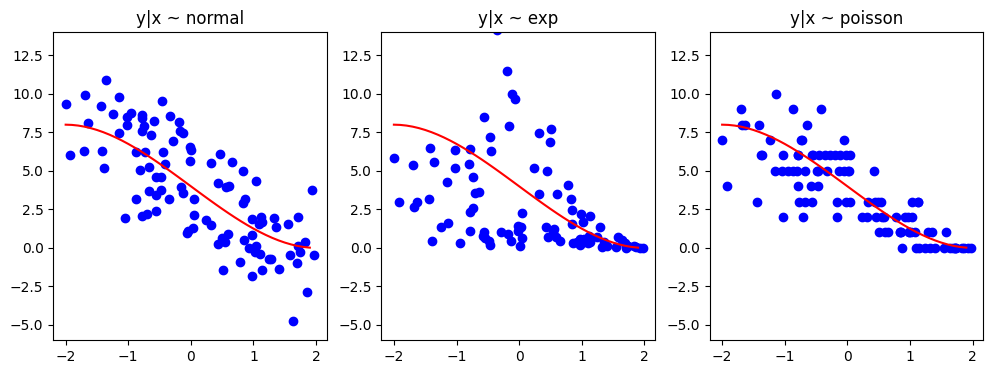

In [ ]:
from scipy.stats import norm, expon, poisson

def f(x):
    return 0.25*x**3 - 3*x + 4

xx = np.arange(-2, 2, 0.1)
yy = f(xx)
N = 100
X = np.random.rand(N)*4 - 2

plt.figure(figsize=(12, 4))

for i, (Y, name) in enumerate([
    (norm.rvs(loc=f(X), scale=2, size=N), 'y|x ~ normal'),
    (expon.rvs(loc=0, scale=f(X), size=N), 'y|x ~ exp'),
    (poisson.rvs(mu=f(X), size=N), 'y|x ~ poisson'),
]):
    plt.subplot(1,3,i+1)
    plt.title(name)
    plt.ylim(-6,14)

    plt.scatter(X, Y, color='blue')
    plt.plot(xx, yy, color='red')

In [ ]:
# @title данные

data = pd.read_csv('/content/sample_data/elon_tweets.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,id,n_mentions,n_urls,tweet_length,MONTH,DAY_OF_WEEK,DAY,HOUR,favorite_count,tfidf_000,...,tfidf_worldandscience,tfidf_worth,tfidf_wow,tfidf_wrong,tfidf_wsj,tfidf_yeah,tfidf_year,tfidf_years,tfidf_yes,tfidf_zero
created_at,,,,,,,,,,,,,,,,,,,,,
2019-03-16 20:05:14+00:00,1107009951266824192,2,0,191,3,5,16,20,7271,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:10:50+00:00,1107011362423599104,3,0,214,3,5,16,20,1401,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:38:07+00:00,1107018227727491073,3,0,312,3,5,16,20,1420,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:45:24+00:00,1107020062177714176,2,0,68,3,5,16,20,4001,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-16 20:53:52+00:00,1107022190426247168,3,0,153,3,5,16,20,742,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2883 entries, 2019-03-16 20:05:14+00:00 to 2020-03-10 05:53:48+00:00
Columns: 509 entries, id to tfidf_zero
dtypes: float64(500), int64(9)
memory usage: 11.2 MB


In [ ]:
def change_categoricals(the_data, list_of_cat_vars):
    # print(the_data.columns)
    for cat_var in list_of_cat_vars:
        df = pd.get_dummies(the_data[cat_var], prefix=cat_var)
        df = df.drop(df.columns[-1], axis=1)

        the_data = the_data.drop(cat_var, axis=1)
        the_data = pd.concat((the_data, df), axis=1)

    return the_data

list_of_cat_vars = ['MONTH', 'DAY_OF_WEEK', 'DAY', 'HOUR']
data = change_categoricals(data, list_of_cat_vars)

In [ ]:
data_train = data[data.index < '2020-02-01']
data_val = data[(data.index >= '2020-02-01') & (data.index < '2020-02-15')]
data_test = data[(data.index >= '2020-02-15') & (data.index < '2020-03-01')]

In [ ]:
y_train = data_train['favorite_count'].values.astype(int)//100
X_train = data_train.drop(axis=1, columns=['favorite_count', 'id'])

y_val = data_val['favorite_count'].values.astype(int)//100
X_val = data_val.drop(axis=1, columns=['favorite_count', 'id'])

y_test = data_test['favorite_count'].values.astype(int)//100
X_test = data_test.drop(axis=1, columns=['favorite_count', 'id'])

In [ ]:
X_train.columns

Index(['n_mentions', 'n_urls', 'tweet_length', 'tfidf_000', 'tfidf_10',
       'tfidf_100', 'tfidf_1000', 'tfidf_12', 'tfidf_13ericralph31',
       'tfidf_20',
       ...
       'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18',
       'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22'],
      dtype='object', length=573)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


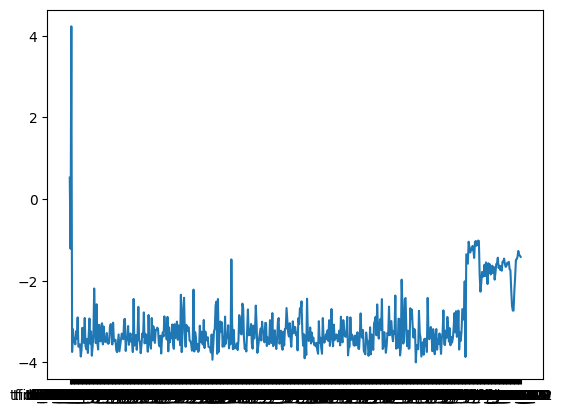

In [ ]:
plt.plot(np.log(X_train.std(axis=0)))

In [ ]:
X_train['intercept'] = [1]*X_train.shape[0]
X_val['intercept'] = [1]*X_val.shape[0]
X_test['intercept'] = [1]*X_test.shape[0]

(array([2.251e+03, 1.530e+02, 6.500e+01, 4.300e+01, 2.700e+01, 1.000e+01,
        1.100e+01, 1.200e+01, 6.000e+00, 7.000e+00, 3.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([2.0000e+00, 3.9770e+02, 7.9340e+02, 1.1891e+03, 1.5848e+03,
        1.9805e+03, 2.3762e+03, 2.7719e+03, 3.1676e+03, 3.5633e+03,
        3.9590e+03, 4.3547e+03, 4.7504e+03, 5.1461e+03, 5.5418e+03,
        5.9375e+03, 6.3332e+03, 6.7289e+03, 7.1246e+03, 7.5203e+03,
        7.9160e+03]),
 <BarContainer object of 20 artists>)

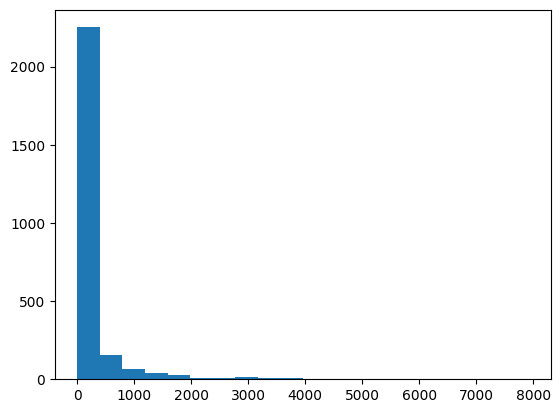

In [ ]:
plt.hist(y_train, bins=20)

In [ ]:
# @title линейная регрессия

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error

LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('MAE MAPE:', mean_absolute_error(y_pred, y_test), mean_absolute_percentage_error(y_pred, y_test))

print(root_mean_squared_error(y_pred, y_test))

MAE MAPE: 341.1682566168595 0.9516433814126818
518.9809173316934


In [ ]:
coef_df = pd.DataFrame({
    'features': pd.DataFrame(X_train).columns,
    'coef': LR.coef_[0]
})
print(coef_df)

         features       coef
0      n_mentions -85.778672
1          n_urls -85.778672
2    tweet_length -85.778672
3       tfidf_000 -85.778672
4        tfidf_10 -85.778672
..            ...        ...
569       HOUR_19 -85.778672
570       HOUR_20 -85.778672
571       HOUR_21 -85.778672
572       HOUR_22 -85.778672
573     intercept -85.778672

[574 rows x 2 columns]


In [ ]:
# @title Разнообразие коэффициента при признаке в зависимости от обучающей выборки

ind = coef_df.loc[coef_df['features'] == 'tweet_length'].index

In [ ]:
from sklearn.utils import resample

mas_tweet_length = []

for i in range(10):
  X_sample, y_sample = resample(X_train, y_train, n_samples=2000, replace=True, random_state=i)
  LR = LinearRegression()
  LR.fit(X_sample, y_sample)
  y_pr = LR.predict(X_test)
  mas_tweet_length.append(y_pr[ind][0])
print(*mas_tweet_length)

4.139649920763134 -33.80161031388789 -99.69927126027784 34.12621745406079 141.93723555370946 848.4814376826934 202.34246472155564 52.81999211778731 -48.79637082426194 107.9202733573166


In [ ]:
# @title Lasso с падбором гиперпараметра

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

Lasso = Lasso()

param = {'alpha': np.logspace(-3, 3, num=7, base=10.)}

rgr = GridSearchCV(Lasso, param_grid=param, scoring=make_scorer(mean_squared_error, greater_is_better=False))
rgr.fit(X_train, y_train)
result = rgr.cv_results_
print(pd.DataFrame(result))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e+05, tolerance: 8.715e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+07, tolerance: 5.215e+04
  model = cd_fast.enet_coordinate_descent(


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0       1.103010      0.550094         0.008632        0.000086        0.001   
1       1.065123      0.590892         0.011189        0.003635        0.010   
2       0.200987      0.020665         0.008541        0.000083        0.100   
3       0.131383      0.024279         0.009224        0.001470        1.000   
4       0.105368      0.001706         0.009238        0.000877       10.000   
5       0.106533      0.010729         0.008860        0.000289      100.000   
6       0.095724      0.001697         0.008549        0.000215     1000.000   

              params  split0_test_score  split1_test_score  split2_test_score  \
0   {'alpha': 0.001}     -315777.669004     -313585.629268     -332741.407753   
1    {'alpha': 0.01}     -304851.047645     -301754.228843     -326109.949567   
2     {'alpha': 0.1}     -245931.615493     -246906.931470     -288786.612102   
3     {'alpha': 1.0}     -168674.82

In [ ]:
best_par = rgr.best_params_['alpha']
print(best_par)

10.0


In [ ]:
from sklearn.linear_model import Lasso

Lasso_best = Lasso(alpha=best_par)

Lasso_best.fit(X_train, y_train)

Lasso_coef = pd.DataFrame({'feat': np.array(coef_df['features']), 'coef': Lasso_best.coef_})
print(Lasso_coef)

             feat        coef
0      n_mentions  -82.454782
1          n_urls -197.470074
2    tweet_length   -0.079614
3       tfidf_000   -0.000000
4        tfidf_10   -0.000000
..            ...         ...
569       HOUR_19    0.000000
570       HOUR_20    0.000000
571       HOUR_21    0.000000
572       HOUR_22   -0.000000
573     intercept    0.000000

[574 rows x 2 columns]


In [ ]:
# @title отобранные признаки

need_coef = Lasso_coef[np.abs(Lasso_coef['coef']) > 10e-10]
print(need_coef)

n_c_mas = np.array(need_coef['feat'])

with open('need_coef.txt', 'w') as f:
  print(*n_c_mas, sep=',', file=f)

             feat        coef
0      n_mentions  -82.454782
1          n_urls -197.470074
2    tweet_length   -0.079614
205   tfidf_https  786.488794


In [ ]:
# @title RMSE(лучше чем в обычной линейной регрессии)

from sklearn.metrics import root_mean_squared_error

print(root_mean_squared_error(Lasso_best.predict(X_test), y_test))

486.104130095509


In [ ]:
# @title T-статистика

X_t_l = X_train.astype('float64')

M = np.linalg.inv(X_t_l.T.dot(X_t_l) + 1e-14*np.eye(X_t_l.shape[1]))
w_pred = M.dot(X_t_l.T).dot(y_train)

T = (w_pred[ind]) / (
    np.sqrt(np.sum( (X_t_l.dot(w_pred) - y_train) ** 2) * M[ind[0]][ind[0]] /
    (X_t_l.shape[0] - X_t_l.shape[1]))
)

print('T statistic =', T)

T statistic = [-0.58988106]


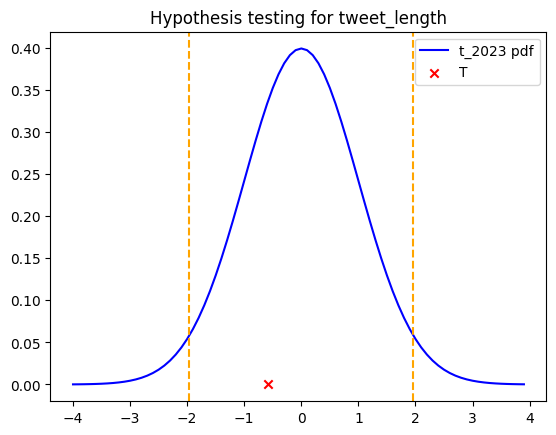

In [ ]:
from scipy import stats

xx = np.arange(-4, 4, 0.1)
df = X_train.shape[0] - X_train.shape[1] # t distribution parameter

plt.title('Hypothesis testing for tweet_length')
plt.plot(xx, stats.t.pdf(xx, df),
         label='t_%d pdf'%(df), color='blue')
plt.scatter([T], [0], marker='x', color='red', label='T')
plt.axvline(x=stats.t.ppf(0.05/2, df),
           linestyle='--', color='orange')
plt.axvline(x=stats.t.ppf(1-0.05/2, df),
           linestyle='--', color='orange')
plt.legend()

In [ ]:
p_value = stats.t.cdf(-np.abs(T), df) + (1 - stats.t.cdf(np.abs(T), df))
print(p_value)

[0.55533627]


In [ ]:
# @title статистика

import statsmodels.api as sm

In [ ]:
sm_ols = sm.OLS(y_train, X_t_l).fit()
sm_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     2.328
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           5.96e-42
Time:                        05:11:00   Log-Likelihood:                -19690.
No. Observations:                2597   AIC:                         4.052e+04
Df Residuals:                    2026   BIC:                         4.387e+04
Df Model:                         570                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
n_mentions              -85.7787     12.641     -6.786      0.000    -110.570     -60.987
n_urls                 -453.1381     50.454     -8.981      0.000    -552.086    -354.190
tweet_length             -0.2178      0.369     -0.590      0.555      -0.942       0.506
tfidf_000                -1.1330    547.486     -0.002      0.998   -1074.828    1072.562
tfidf_10               -125.4558    294.143     -0.427      0.670    -702.310     451.398
tfidf_100              -134.1533    420.953     -0.319      0.750    -959.700     691.394
tfidf_1000               -3.6906    390.483     -0.009      0.992    -769.481     762.100
tfidf_12                 37.6520    480.986      0.078      0.938    -905.627     980.932
tfidf_13ericralph31     754.1754    384.797      1.960      0.050      -0.464    1508.815
tfidf_20                -79.0320    364.402     -0.217      0.828    -793.674     635.610
tfidf_28delayslater      49.0373    216.849      0.226      0.821    -376.232     474.307
tfidf_30               -718.2099    471.661     -1.523      0.128   -1643.200     206.781
tfidf_46txqrrsdr         34.0464    521.198      0.065      0.948    -988.093    1056.186
tfidf_60                -88.9157    465.816     -0.191      0.849   -1002.444     824.613
tfidf__mikemo           -17.5159    308.176     -0.057      0.955    -621.890     586.858
tfidf_able             -152.2430    480.568     -0.317      0.751   -1094.701     790.215
tfidf_absolutely        -37.7684    265.013     -0.143      0.887    -557.495     481.958
tfidf_access           -325.6724    493.339     -0.660      0.509   -1293.176     641.831
tfidf_actual           -281.5103    404.239     -0.696      0.486   -1074.277     511.257
tfidf_actually          823.8171    216.561      3.804      0.000     399.111    1248.523
tfidf_add                56.5592    432.798      0.131      0.896    -792.215     905.334
tfidf_adding            536.7193    500.883      1.072      0.284    -445.581    1519.020
tfidf_advanced            2.3352    350.223      0.007      0.995    -684.500     689.171
tfidf_aerojetrdyne     -181.8897   1165.018     -0.156      0.876   -2466.649    2102.869
tfidf_ago               363.3604    354.998      1.024      0.306    -332.839    1059.560
tfidf_agreed             -3.5723    212.865     -0.017      0.987    -421.030     413.885
tfidf_aiming           -134.5891    416.586     -0.323      0.747    -951.571     682.393
tfidf_air               -64.2583    309.324     -0.208      0.835    -670.885     542.368
tfidf_aircraft          111.3105    600.605      0.185      0.853   -1066.557    1289.179
tfidf_allow             227.2064    442.960      0.513      0.608    -641.498    1095.910
tfidf_amazing          -317.5664    334.413     -0.950      0.342    -973.395     338.263
tfidf_amp              

In [ ]:
p_v = sm_ols.pvalues
main_feat = np.array(p_v[p_v <= 0.05].index)
print(*main_feat, sep='\n')
with open('feat.txt', 'w') as f:
  print(*main_feat, sep=',', file=f)

n_mentions
n_urls
tfidf_actually
tfidf_area
tfidf_art
tfidf_color
tfidf_complete
tfidf_cybertruck
tfidf_day
tfidf_free
tfidf_game
tfidf_going
tfidf_happy
tfidf_home
tfidf_https
tfidf_insane
tfidf_life
tfidf_long
tfidf_oxygen
tfidf_simulation
tfidf_sounds
tfidf_travel
tfidf_video
tfidf_yes
MONTH_3
MONTH_4
MONTH_6
MONTH_7
MONTH_9
DAY_17
DAY_23
HOUR_1
HOUR_22
intercept


In [ ]:
# @title линейная регрессия с отобранными по pvalues параметрами

L_R_stat = LinearRegression()
L_R_stat.fit(X_train[main_feat], y_train)
y_pred = L_R_stat.predict(X_test[main_feat])
print('RMSE MAPE:', root_mean_squared_error(y_pred, y_test), mean_absolute_percentage_error(y_pred, y_test))

RMSE MAPE: 499.8356212916951 0.9528371163629363


In [ ]:
# @title AIC отбор

all_feat = set(pd.DataFrame(X_train).columns)
all_feat.remove('intercept')
picked_feat = ['intercept']

for i in range(39):
  rait = []
  for j in tqdm(all_feat):
    arg = [k for k in picked_feat]
    arg.append(j)
    AIC = sm.OLS(y_train, X_t_l[arg]).fit().aic
    rait.append((AIC, j))
  pick = min(rait, key=lambda x: x[0])[1]
  picked_feat.append(pick)
  all_feat.remove(pick)
print(picked_feat)

['intercept', 'tfidf_https', 'n_mentions', 'n_urls', 'tfidf_cybertruck', 'tfidf_art', 'tfidf_insane', 'tfidf_game', 'tfidf_happy', 'tfidf_life', 'tfidf_actually', 'tfidf_free', 'tfidf_simulation', 'tfidf_orion_sword', 'tfidf_travel', 'tfidf_going', 'tfidf_oxygen', 'tfidf_area', 'MONTH_1', 'tfidf_color', 'tfidf_space', 'tfidf_complete', 'tfidf_video', 'tfidf_home', 'tfidf_light', 'tfidf_haha', 'tfidf_day', 'tfidf_shanghai', 'tfidf_mkbhd', 'tfidf_single', 'tfidf_twitter', 'MONTH_10', 'tfidf_way', 'tfidf_just', 'tfidf_13ericralph31', 'tweet_length', 'tfidf_nichegamer', 'tfidf_yes', 'tfidf_speed', 'tfidf_don']


In [ ]:
# @title RMSE отбора

with open('aic_picked.txt', 'w')as f:
  print(*picked_feat, sep=',', file=f)

sm_ols = sm.OLS(y_train, X_t_l[picked_feat]).fit()
sm_pr = sm_ols.predict(X_test[picked_feat].astype('float64'))
print('RMSE:', root_mean_squared_error(sm_pr, y_test))

RMSE: 495.01885902360965
